# Process
In this notebook, I will do a first analysis of gender distribution on the data so that I can use it later on.

## A. Import Libraries

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import random as rd
import pandas as pd
import numpy as np
from analyze_data import users_and_items, user_distribution,user_gender_distribution, calculate_group_characteristics
from plots import plot_gender_difference_distribution, plot_profile_size_vs_gender_difference, plot_group_characteristics
import tqdm 
from split_users import sort_user_dist, split, split_differently
import time
import pickle as pkl
from sklearn.model_selection import train_test_split
pd.set_option("display.precision", 5)

## B. Set hyperparameters
There are certain hyperparameters that need to be tuned before the run. 

In [2]:
item_threshold = 5 # remove users with less than item_threshold items
user_threshold = 5 # remove items with less than user_threshold users
top_threshold = 200 # remove users who have rated more than top_threshold items
recommendation_type = "books" # books, music or movies
item_col = "ISBN" # the item column
user_col = "User-ID"
my_seed = 0 # random_seed
top_fraction_users = 0.2# the limit for a user to be considered High Male Preference
split_by = "male_female_difference" 

These additions will be useful so we can save the different files (plots and processed data) with clarity on the hyperparameters.

In [3]:
addition_1 = "_u"+str(item_threshold)+"_i"+str(user_threshold)+"_t"+str(top_threshold)
addition_2 = addition_1 + "_tfu"+str(int(100*top_fraction_users))
addition_3 = addition_2 + ("_mfd" if (split_by=="male_female_difference") else "_unknown")

In [24]:
addition_3

'_u5_i5_t200_tfu20_mfd'

In [4]:
rd.seed(my_seed) #seed for random functions
np.random.seed(my_seed) #seed for all numpy fuctions

## C. Read files

In [26]:
processed_file_location = "data/processed/" # here we store the processed data files

In [5]:
properties_file_location = "data/files_with_properties/" # here are stored the data files that include author properties
item_file = properties_file_location + "fairbook_books.csv" # the items file
items_with_properties = pd.read_csv(item_file, index_col=0, header=0, low_memory=False).fillna("")

ratings_file = properties_file_location + "fairbook_ratings.csv" # the ratings file
ratings_with_properties = pd.read_csv(ratings_file, index_col=0, header=0, low_memory=False).fillna("")

In [6]:
ratings_with_properties.head()

,User-ID,ISBN,Book-Rating,QID,viaf_id,sexuality,country,language,religion,gender,ethnicity,birthyear,deathyear,title,author,year,publisher
0,276847,3426029553,8,,,,,,,,,,,,,,
1,276847,3551551677,10,Q34660,116796842,,United Kingdom,English,Anglicanism,female,English people,1965.0,,Harry Potter und der Stein der Weisen,Joanne K. Rowling,1999.0,Carlsen Verlag GmbH
2,276847,3551551685,10,Q34660,116796842,,United Kingdom,English,Anglicanism,female,English people,1965.0,,Harry Potter und die Kammer des Schreckens,Joanne K. Rowling,2000.0,Carlsen Verlag GmbH
3,276847,3551551693,10,Q34660,116796842,,United Kingdom,English,Anglicanism,female,English people,1965.0,,Harry Potter und der Gefangene von Azkaban,J. K. Rowling,1999.0,Carlsen Verlag GmbH
4,276847,3551551936,10,Q34660,116796842,,United Kingdom,English,Anglicanism,female,English people,1965.0,,Harry Potter Und Der Feuerkelch,Joanne K. Rowling,1999.0,Carlsen Verlag GmbH


## D. Preprocess data
1. Convert book IDs into numbers (needed for Cornac).

In [7]:
mapping_dict = {} # Create a dictionary that maps each ISBN to an integer.
i=0
for ISBN in ratings_with_properties.ISBN.unique():
    mapping_dict[ISBN] = i
    i+=1

In [8]:
items_with_properties.ISBN = items_with_properties.ISBN.map(lambda x: mapping_dict.get(x,x)) # Map in the books file
ratings_with_properties.ISBN = ratings_with_properties.ISBN.map(lambda x: mapping_dict.get(x,x)) # Map in the books file

In [9]:
ratings_with_properties.head(2)

,User-ID,ISBN,Book-Rating,QID,viaf_id,sexuality,country,language,religion,gender,ethnicity,birthyear,deathyear,title,author,year,publisher
0,276847,0,8,,,,,,,,,,,,,,
1,276847,1,10,Q34660,116796842,,United Kingdom,English,Anglicanism,female,English people,1965.0,,Harry Potter und der Stein der Weisen,Joanne K. Rowling,1999.0,Carlsen Verlag GmbH


## E. Gender analysis

First, I am replacing empty gender entries with "unknown" and all the non male or female with "other".

In [10]:
df = ratings_with_properties.copy()
df["gender"] = df["gender"].apply(lambda x: "unknown" if x=="" else x)
df["gender"] = df["gender"].apply(lambda x: "other" if (x!="male") & (x!="female") & (x!="unknown") else x)


Here is a plot of the gender distribution within the ratings.

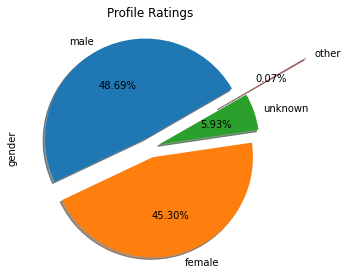

In [11]:
fig, ax = plt.subplots()
df.gender.value_counts().plot(kind="pie",autopct='%.2f%%',explode=(0.1, 0.1, 0.1,0.8), shadow=True
                                      , startangle=30)
ax.tick_params(labelrotation=0)
ax.title.set_text("Profile Ratings")
fig.tight_layout()

## F. Define and calculate gender odds

First, I will keep only the relevant columns.

In [12]:
df = df[["User-ID", "ISBN", "Book-Rating", "gender"]]

In [13]:
df.head()

,User-ID,ISBN,Book-Rating,gender
0,276847,0,8,unknown
1,276847,1,10,female
2,276847,2,10,female
3,276847,3,10,female
4,276847,4,10,female


Then, I call a function to calculate the gender distribution per user.

The way I do it is by calculating: <br>
mw = number of books in profile written by male authors<br>
fw = number of books in profile written by female authors<br>
tb = number of books in profile <br>

<u>So for every user u, I define <i>male_female_difference</i> as:</u>

male_female_difference(u) = (mw(u) - fw(u))/tb(u)

In [14]:
user_gender_dist, num_users = user_gender_distribution(df, user_col, split_by,  prnt = True)

Mean male_female_differences per user: 0.05631
Standard deviation of male_female_differences per user: 0.51457
Min male_female_differences per user: -1.0
Max male_female_differences per user: 1.0


In [15]:
user_gender_dist

,num_female,num_male,num_other,num_unknown,num_total,ratio_female,male_female_difference
258107,6,0,0,0,6,1.0,-1.0
177876,5,0,0,0,5,1.0,-1.0
178458,5,0,0,0,5,1.0,-1.0
86170,6,0,0,0,6,1.0,-1.0
179321,5,0,0,0,5,1.0,-1.0
...,...,...,...,...,...,...,...
112512,0,7,0,0,7,0.0,1.0
30838,0,6,0,0,6,0.0,1.0
148798,0,6,0,0,6,0.0,1.0
242639,0,16,0,0,16,0.0,1.0


## G. Plot gender distribution among users 

First, I will plot the sorted differences.

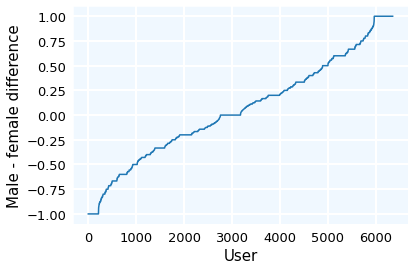

In [16]:
plot_gender_difference_distribution(user_gender_dist.male_female_difference.values)

R-value: -0.04365697959637796


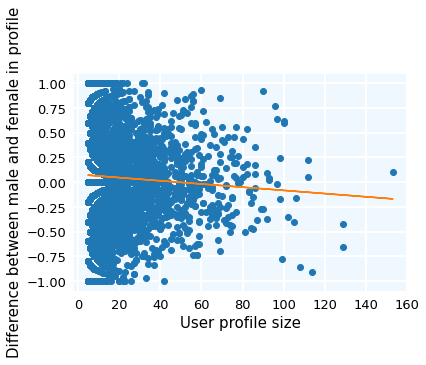

In [17]:
plot_profile_size_vs_gender_difference(user_gender_dist.male_female_difference.values,user_gender_dist.num_total.values)

## H. Divide users

First, I will divide the users into low male preference, medium male preference and high male preference.

In [18]:
low, med, high = split(user_gender_dist, top_fraction_users)

In [19]:
low_profile_size, med_profile_size, high_profile_size, low_nr_users, med_nr_users, high_nr_users = calculate_group_characteristics(low, med, high, count_column = "num_total", way = "gender")

Female Oriented: 12.39
Diverse: 15.69
Male Oriented: 10.17


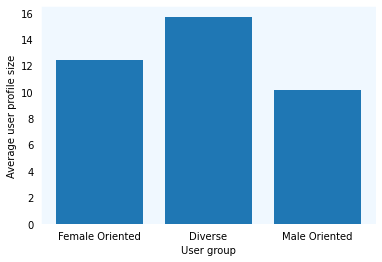

In [20]:
plot_group_characteristics(low_profile_size, med_profile_size, high_profile_size,analysis_type = "gender")

Female Oriented: 1271
Diverse: 3815
Male Oriented: 1272


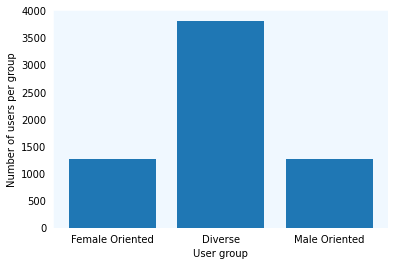

In [21]:
plot_group_characteristics(low_nr_users, med_nr_users, high_nr_users,analysis_type = "gender", way = "number of users")

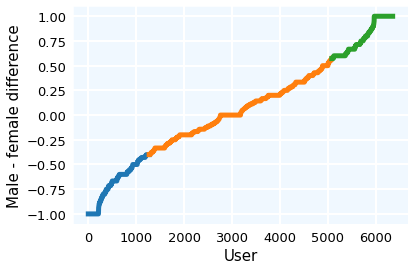

In [22]:
plot_gender_difference_distribution(user_gender_dist.male_female_difference.values, dividing = [True,top_fraction_users])

## I. Save Processed Data
Now we will save all the files that are needed for training the Recommender Systems and analyzing the results.
1. The Female Oriented, Diverse and Male Oriented users.
(We have already saved the "mapped" files.

In [27]:
low.to_csv(processed_file_location + recommendation_type +"/low_users"+addition_3+".csv")
med.to_csv(processed_file_location +recommendation_type + "/med_users"+addition_3+".csv")
high.to_csv(processed_file_location +recommendation_type + "/high_users"+addition_3+".csv")